Script Name: SZCDCRNN

Author: Fatemeh Delavari  
Original Version: (04/30/2025)
Version: 4.0 (05/07/2025)  
Description: Seizure type Classification using Diffusion Convolutional Recurrent Neural Network

In [1]:
# Get the pretrained weights and biases 
# [for when the model is pretrianed given 12 second long EEGs and distance based adjacencies]

import torch
model_pre = torch.load('pretrained_distance_graph_12s.pth.tar')

# Convert dict_values to list
state_dict_list = list(model_pre.values())
# Now, the first element is an OrderedDict
first_ordered_dict = state_dict_list[0]
# Extract its items (key, tensor)
first_items = list(first_ordered_dict.items())
# Get the first tensor
first_tensor = first_items[0][1]
# Print the shape
print(first_tensor.shape)
# Get the first tensor
second_tensor = first_items[1][1]
# Print the shape
print(second_tensor.shape)

torch.Size([492, 128])
torch.Size([128])


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sklearn
import os
import mne
import pickle

# Specify the folder path containing the EDF files
folder_path = 'C:/Users/Atena/Documents/edf_files'
# Specify the folder path containing the CSV files
folder_path_csv = 'C:/Users/Atena/Documents/csv_files'

# Constants
num_channels = 19
epoch_length = 1  # in seconds
electrodes = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'T3', 'C3', 'CZ', 'C4', 'T4', 'T5', 'P3', 'PZ', 'P4', 'T6', 'O1', 'O2']
electrode_locations = {
    'FP1': (-0.3, 0.8),
    'FP2': (0.3, 0.8),
    'F7': (-0.7, 0.5),
    'F3': (-0.4, 0.4),
    'FZ': (0.0, 0.3),
    'F4': (0.4, 0.4),
    'F8': (0.7, 0.5),
    'T3': (-0.8, 0),
    'C3': (-0.5, 0.0),
    'CZ': (0.0, 0.0),
    'C4': (0.5, 0.0),
    'T4': (0.8, 0),
    'T5': (-0.6, -0.5),
    'P3': (-0.4, -0.4),
    'PZ': (0.0, -0.3),
    'P4': (0.4, -0.4),
    'T6': (0.6, -0.5),
    'O1': (-0.3, -0.8),
    'O2': (0.3, -0.8)
    }
# Define the Butterworth filter parameters with filtfilt applied
iir_params = dict(order=6, ftype='butter', output='sos')

# Define the functions to be used
from scipy.signal import hilbert, butter, filtfilt
def bandpass_filter(data, sfreq, low_freq, high_freq):
    """
    Band-pass filter the data.
    
    Parameters:
    data (ndarray): The input signal of shape (n_channels, n_times)
    sfreq (float): The sampling frequency
    low_freq (float): The lower bound of the frequency range
    high_freq (float): The upper bound of the frequency range
    
    Returns:
    filtered_data (ndarray): The band-pass filtered signal
    """
    nyquist = 0.5 * sfreq
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data

def epoch_data(data, sfreq, epoch_length):
    n_channels, n_samples = data.shape
    epoch_samples = int(epoch_length * sfreq)
    n_epochs = n_samples // epoch_samples
    epochs = np.array_split(data[:, :n_epochs * epoch_samples], n_epochs, axis=1)
    return epochs, n_epochs

def extract_sz_channels(file_path, sztype):
    """
    Extract channel names corresponding to rows with the label '--sz' for each start and stop time,
    merging times that are 5 seconds or less apart into the earliest time for start and largest for stop.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        dict: A dictionary where keys are tuples of (merged_start_time, merged_stop_time)
              and values are lists of channel names.
    """
    try:
        # Load CSV data, skipping lines that start with '#'
        data = pd.read_csv(file_path, comment='#')

        # Filter rows with the label 'sz'
        sz_data = data[data['label'] == sztype]

        # Sort and merge start times if they are within 1800 seconds
        sorted_start_times = sorted(sz_data['start_time'].unique())
        merged_start_times = []
        current_group = [sorted_start_times[0]]

        for i in range(1, len(sorted_start_times)):
            if sorted_start_times[i] - current_group[-1] <= 10:
                current_group.append(sorted_start_times[i])
            else:
                merged_start_times.append(current_group)
                current_group = [sorted_start_times[i]]
        merged_start_times.append(current_group)  # Add the last group

        start_time_mapping = {
            time: group[0] for group in merged_start_times for time in group
        }

        # Map each start time to the merged start time
        sz_data['merged_start_time'] = sz_data['start_time'].map(start_time_mapping)

        # Sort and merge stop times if they are within 1800 seconds
        sorted_stop_times = sorted(sz_data['stop_time'].unique())
        merged_stop_times = []
        current_group = [sorted_stop_times[0]]

        for i in range(1, len(sorted_stop_times)):
            if sorted_stop_times[i] - current_group[-1] <= 10:
                current_group.append(sorted_stop_times[i])
            else:
                merged_stop_times.append(current_group)
                current_group = [sorted_stop_times[i]]
        merged_stop_times.append(current_group)  # Add the last group

        stop_time_mapping = {
            time: group[-1] for group in merged_stop_times for time in group
        }

        # Map each stop time to the merged stop time
        sz_data['merged_stop_time'] = sz_data['stop_time'].map(stop_time_mapping)

        channelslist = list(sz_data['channel'])

        from collections import Counter
        nested_list = [channels.split('-') for channels in channelslist]
        flat_list = [item for sublist in nested_list for item in sublist]
        count_dict = Counter(flat_list)
        foz_channels = [key for key, value in count_dict.items() if value >= 2]

        focal_zone_channels = {(list(sz_data['merged_start_time'])[0], list(sz_data['merged_stop_time'])[0]): foz_channels}

        return focal_zone_channels

    except Exception as e:
        print(f"Error processing file '{file_path}': {e}")
        return {}
    
n_segments = 12
n_channels = 19
n_freqs = 100

In [7]:
def compute_log_fft_features(eeg_array, n_freqs=100, epsilon=1e-6):
    """Compute log FFT amplitude features for a [19 × sfreq] EEG segment."""
    n_channels, n_samples = eeg_array.shape
    
    fft_features = np.zeros((n_channels, n_freqs))
    for ch in range(n_channels):
        fft_result = np.fft.rfft(eeg_array[ch])
        fft_amp = np.abs(fft_result)
        fft_features[ch] = np.log(fft_amp[:n_freqs] + epsilon)
    
    return fft_features  # shape: (19, n_freqs)

In [ ]:
from scipy.signal import stft

def compute_log_stft_features(eeg_array, fs, window_size=64, n_fft=64, epsilon=1e-6, n_time_steps=12):
    """
    Compute log STFT amplitude features for a [19 × sfreq] EEG segment.

    Parameters:
        eeg_array: np.ndarray of shape (19, n_samples)
        fs: sampling frequency (Hz)
        window_size: length of each STFT window (in samples)
        n_fft: number of FFT points
        epsilon: small value to avoid log(0)
        n_time_steps: desired number of time steps in the output

    Returns:
        features_tensor: np.ndarray of shape (n_freqs, n_time_steps, 19)
    """
    n_channels, n_samples = eeg_array.shape
    assert n_channels == 19, "Input EEG must have 19 channels."

    # Calculate hop size to produce exactly n_time_steps
    hop_size = int((n_samples - window_size) / (n_time_steps - 1))+1
    assert hop_size > 0, "Computed hop size must be positive. Check input dimensions."

    all_stft_features = []

    for ch in range(n_channels):
        f, t, Zxx = stft(
            eeg_array[ch], fs=fs,
            nperseg=window_size,
            noverlap=window_size - hop_size,
            nfft=n_fft,
            boundary=None  # prevents padding
        )
        stft_magnitude = np.abs(Zxx[:n_fft // 2])  # (n_freqs, n_time_steps)
        log_power = np.log10(stft_magnitude + epsilon)
        all_stft_features.append(log_power.T)  # transpose: (n_time_steps, n_freqs)

    # Stack into (n_time_steps, n_freqs, n_channels), then transpose
    features_tensor = np.stack(all_stft_features, axis=1)  # shape: (n_time_steps, n_freqs, 19)
    # features_tensor = features_tensor.transpose(1, 0, 2)   # final shape: (n_freqs, n_time_steps, 19)

    return features_tensor

Feature shape: (12, 19, 32)


In [ ]:
# process the data 

# eegsfn = []
# seizure_types = ['fnsz']

# # Load the saved data
# with open('FNSZ1.pkl', "rb") as f: 
#     loaded_data = pickle.load(f)
# csv_file_names = loaded_data 

# for file_num in range(0, len(csv_file_names)):
#     print(file_num)
        
#     csv_file_name = csv_file_names[file_num]
#     csv_file_path = os.path.join(folder_path_csv, csv_file_name)
#     # Read the CSV file
#     df = pd.read_csv(csv_file_path, comment='#') 

#     # Extract the unique labels from the 'label' column, ignoring case sensitivity
#     unique_labels = df['label'].str.lower().unique()
#     FOZ = {}
#     for sztype in seizure_types:
#         sznum = seizure_types.index(sztype)
        
#         # Find matching labels (case-insensitive comparison)
#         matching_labels = [label for label in unique_labels if label==sztype]

#         # Convert the label column to lowercase for case-insensitive matching
#         df['label'] = df['label'].str.lower()

#         # Filter the rows that match the target labels
#         matching_df = df[df['label']==sztype]

#         # Check if any label contains 'sz'
#         if any(sztype in label for label in unique_labels):
#             channels = extract_sz_channels(csv_file_path, sztype)
#             # Create a modified dictionary based on the logic
#             channels_presence = {szt: np.array([1 if electrode in chans else 0 for electrode in electrodes]).T for szt, chans in channels.items()}

#             FOZ = channels_presence

#     seiz_start = list(FOZ.keys())[0][0]
#     seiz_stop = list(FOZ.keys())[0][1]
#     # Strip the .edf extension and look for the corresponding .csv file
#     base_name = os.path.splitext(csv_file_name)[0]
            
#     edf_file_name = base_name + '.edf'
#     file_path = os.path.join(folder_path, edf_file_name)
        
#     # Read the EDF file
#     raw = mne.io.read_raw_edf(file_path, preload=True)
#     dat, times = raw[:]
#     sfreq = int(raw.info['sfreq'])

#     data = dat[:, int(round((seiz_start)*sfreq)):int(round((seiz_stop)*sfreq))]
#     chs = raw.ch_names
#     # Extract the info from the original raw object to preserve metadata
#     info = raw.info

#     modified_raw = mne.io.RawArray(data, info)

#     # Define channel selection and renaming
#     if any('REF' in ch for ch in chs):
#         ref_suffix = '-REF'
#     else:
#         ref_suffix = '-LE'

#     selected_channels = [
#         f'EEG FP1{ref_suffix}', f'EEG FP2{ref_suffix}', f'EEG F7{ref_suffix}', f'EEG F3{ref_suffix}',
#         f'EEG FZ{ref_suffix}', f'EEG F4{ref_suffix}', f'EEG F8{ref_suffix}', f'EEG T3{ref_suffix}',
#         f'EEG C3{ref_suffix}', f'EEG CZ{ref_suffix}', f'EEG C4{ref_suffix}', f'EEG T4{ref_suffix}',
#         f'EEG T5{ref_suffix}', f'EEG P3{ref_suffix}', f'EEG PZ{ref_suffix}', f'EEG P4{ref_suffix}',
#         f'EEG T6{ref_suffix}', f'EEG O1{ref_suffix}', f'EEG O2{ref_suffix}'
#     ]

#     rename_dict = {ch: ch.replace(f'EEG ', '').replace(ref_suffix, '') for ch in selected_channels}

#     raw_selected = modified_raw.copy()
    
#     # Get the list of available channels
#     available_channels = raw_selected.info["ch_names"]

#     # Find missing channels
#     missing_channels = [ch for ch in selected_channels if ch not in available_channels]

#     # Raise an error or handle missing channels
#     if missing_channels==[]:
#         # Select the specified channels
#         raw_selected = raw_selected.pick_channels(selected_channels)

#         # Apply renaming
#         raw_selected.rename_channels(rename_dict)

#         # Filter the data
#         preprocEEG = raw_selected.copy()
#         # # Band-pass filter the data using a 6th-order Butterworth filter with filtfilt applied
#         # preprocEEG.filter(l_freq=1.0, h_freq=40, method='iir', iir_params=iir_params, phase='zero')
#         # Notch filter to remove power line noise (assuming 60 Hz)
#         preprocEEG.notch_filter(freqs=60.0)

#         eegICA = preprocEEG

#         eegICA.set_eeg_reference(ref_channels='average')

#         eeg_data, times = eegICA[:]
#         eeg_epochs, n_epochs = epoch_data(eeg_data, sfreq, epoch_length)

#         n_segments = len(eeg_epochs)
#         # features = []
#         for g, segment in enumerate(eeg_epochs):
#             eegsfn.append((compute_log_stft_features(segment, sfreq)))


# eegsgn = []
# seizure_types = ['gnsz']

# # Load the saved data
# with open('GNSZ1.pkl', "rb") as f: 
#     loaded_data = pickle.load(f)
# csv_file_names = loaded_data 

# for file_num in range(0, len(csv_file_names)):
#     print(file_num)
        
#     csv_file_name = csv_file_names[file_num]
#     csv_file_path = os.path.join(folder_path_csv, csv_file_name)
#     # Read the CSV file
#     df = pd.read_csv(csv_file_path, comment='#') 

#     # Extract the unique labels from the 'label' column, ignoring case sensitivity
#     unique_labels = df['label'].str.lower().unique()
#     FOZ = {}
#     for sztype in seizure_types:
#         sznum = seizure_types.index(sztype)
        
#         # Find matching labels (case-insensitive comparison)
#         matching_labels = [label for label in unique_labels if label==sztype]

#         # Convert the label column to lowercase for case-insensitive matching
#         df['label'] = df['label'].str.lower()

#         # Filter the rows that match the target labels
#         matching_df = df[df['label']==sztype]

#         # Check if any label contains 'sz'
#         if any(sztype in label for label in unique_labels):
#             channels = extract_sz_channels(csv_file_path, sztype)
#             # Create a modified dictionary based on the logic
#             channels_presence = {szt: np.array([1 if electrode in chans else 0 for electrode in electrodes]).T for szt, chans in channels.items()}

#             FOZ = channels_presence

#     seiz_start = list(FOZ.keys())[0][0]
#     seiz_stop = list(FOZ.keys())[0][1]
#     # Strip the .edf extension and look for the corresponding .csv file
#     base_name = os.path.splitext(csv_file_name)[0]
            
#     edf_file_name = base_name + '.edf'
#     file_path = os.path.join(folder_path, edf_file_name)
        
#     # Read the EDF file
#     raw = mne.io.read_raw_edf(file_path, preload=True)
#     dat, times = raw[:]
#     sfreq = int(raw.info['sfreq'])

#     data = dat[:, int(round((seiz_start)*sfreq)):int(round((seiz_stop)*sfreq))]
#     chs = raw.ch_names
#     # Extract the info from the original raw object to preserve metadata
#     info = raw.info

#     modified_raw = mne.io.RawArray(data, info)

#     # Define channel selection and renaming
#     if any('REF' in ch for ch in chs):
#         ref_suffix = '-REF'
#     else:
#         ref_suffix = '-LE'

#     selected_channels = [
#         f'EEG FP1{ref_suffix}', f'EEG FP2{ref_suffix}', f'EEG F7{ref_suffix}', f'EEG F3{ref_suffix}',
#         f'EEG FZ{ref_suffix}', f'EEG F4{ref_suffix}', f'EEG F8{ref_suffix}', f'EEG T3{ref_suffix}',
#         f'EEG C3{ref_suffix}', f'EEG CZ{ref_suffix}', f'EEG C4{ref_suffix}', f'EEG T4{ref_suffix}',
#         f'EEG T5{ref_suffix}', f'EEG P3{ref_suffix}', f'EEG PZ{ref_suffix}', f'EEG P4{ref_suffix}',
#         f'EEG T6{ref_suffix}', f'EEG O1{ref_suffix}', f'EEG O2{ref_suffix}'
#     ]

#     rename_dict = {ch: ch.replace(f'EEG ', '').replace(ref_suffix, '') for ch in selected_channels}

#     raw_selected = modified_raw.copy()
    
#     # Get the list of available channels
#     available_channels = raw_selected.info["ch_names"]

#     # Find missing channels
#     missing_channels = [ch for ch in selected_channels if ch not in available_channels]

#     # Raise an error or handle missing channels
#     if missing_channels==[]:
#         # Select the specified channels
#         raw_selected = raw_selected.pick_channels(selected_channels)

#         # Apply renaming
#         raw_selected.rename_channels(rename_dict)

#         # Filter the data
#         preprocEEG = raw_selected.copy()
#         # # Band-pass filter the data using a 6th-order Butterworth filter with filtfilt applied
#         # preprocEEG.filter(l_freq=1.0, h_freq=40, method='iir', iir_params=iir_params, phase='zero')
#         # Notch filter to remove power line noise (assuming 60 Hz)
#         preprocEEG.notch_filter(freqs=60.0)

#         eegICA = preprocEEG

#         eegICA.set_eeg_reference(ref_channels='average')

#         eeg_data, times = eegICA[:]
#         eeg_epochs, n_epochs = epoch_data(eeg_data, sfreq, epoch_length)

#         n_segments = len(eeg_epochs)
#         # features = []
#         for g, segment in enumerate(eeg_epochs):
#             eegsgn.append((compute_log_stft_features(segment, sfreq)))


# eegsab = []
# seizure_types = ['absz']

# # Load the saved data
# with open('ABSZ1.pkl', "rb") as f: 
#     loaded_data = pickle.load(f)
# csv_file_names = loaded_data 

# for file_num in range(0, len(csv_file_names)):
#     print(file_num)
        
#     csv_file_name = csv_file_names[file_num]
#     csv_file_path = os.path.join(folder_path_csv, csv_file_name)
#     # Read the CSV file
#     df = pd.read_csv(csv_file_path, comment='#') 

#     # Extract the unique labels from the 'label' column, ignoring case sensitivity
#     unique_labels = df['label'].str.lower().unique()
#     FOZ = {}
#     for sztype in seizure_types:
#         sznum = seizure_types.index(sztype)
        
#         # Find matching labels (case-insensitive comparison)
#         matching_labels = [label for label in unique_labels if label==sztype]

#         # Convert the label column to lowercase for case-insensitive matching
#         df['label'] = df['label'].str.lower()

#         # Filter the rows that match the target labels
#         matching_df = df[df['label']==sztype]

#         # Check if any label contains 'sz'
#         if any(sztype in label for label in unique_labels):
#             channels = extract_sz_channels(csv_file_path, sztype)
#             # Create a modified dictionary based on the logic
#             channels_presence = {szt: np.array([1 if electrode in chans else 0 for electrode in electrodes]).T for szt, chans in channels.items()}

#             FOZ = channels_presence

#     seiz_start = list(FOZ.keys())[0][0]
#     seiz_stop = list(FOZ.keys())[0][1]
#     # Strip the .edf extension and look for the corresponding .csv file
#     base_name = os.path.splitext(csv_file_name)[0]
            
#     edf_file_name = base_name + '.edf'
#     file_path = os.path.join(folder_path, edf_file_name)
        
#     # Read the EDF file
#     raw = mne.io.read_raw_edf(file_path, preload=True)
#     dat, times = raw[:]
#     sfreq = int(raw.info['sfreq'])

#     data = dat[:, int(round((seiz_start)*sfreq)):int(round((seiz_stop)*sfreq))]
#     chs = raw.ch_names
#     # Extract the info from the original raw object to preserve metadata
#     info = raw.info

#     modified_raw = mne.io.RawArray(data, info)

#     # Define channel selection and renaming
#     if any('REF' in ch for ch in chs):
#         ref_suffix = '-REF'
#     else:
#         ref_suffix = '-LE'

#     selected_channels = [
#         f'EEG FP1{ref_suffix}', f'EEG FP2{ref_suffix}', f'EEG F7{ref_suffix}', f'EEG F3{ref_suffix}',
#         f'EEG FZ{ref_suffix}', f'EEG F4{ref_suffix}', f'EEG F8{ref_suffix}', f'EEG T3{ref_suffix}',
#         f'EEG C3{ref_suffix}', f'EEG CZ{ref_suffix}', f'EEG C4{ref_suffix}', f'EEG T4{ref_suffix}',
#         f'EEG T5{ref_suffix}', f'EEG P3{ref_suffix}', f'EEG PZ{ref_suffix}', f'EEG P4{ref_suffix}',
#         f'EEG T6{ref_suffix}', f'EEG O1{ref_suffix}', f'EEG O2{ref_suffix}'
#     ]

#     rename_dict = {ch: ch.replace(f'EEG ', '').replace(ref_suffix, '') for ch in selected_channels}

#     raw_selected = modified_raw.copy()
    
#     # Get the list of available channels
#     available_channels = raw_selected.info["ch_names"]

#     # Find missing channels
#     missing_channels = [ch for ch in selected_channels if ch not in available_channels]

#     # Raise an error or handle missing channels
#     if missing_channels==[]:
#         # Select the specified channels
#         raw_selected = raw_selected.pick_channels(selected_channels)

#         # Apply renaming
#         raw_selected.rename_channels(rename_dict)

#         # Filter the data
#         preprocEEG = raw_selected.copy()
#         # # Band-pass filter the data using a 6th-order Butterworth filter with filtfilt applied
#         # preprocEEG.filter(l_freq=1.0, h_freq=40, method='iir', iir_params=iir_params, phase='zero')
#         # Notch filter to remove power line noise (assuming 60 Hz)
#         preprocEEG.notch_filter(freqs=60.0)

#         eegICA = preprocEEG

#         eegICA.set_eeg_reference(ref_channels='average')

#         eeg_data, times = eegICA[:]
#         eeg_epochs, n_epochs = epoch_data(eeg_data, sfreq, epoch_length)

#         n_segments = len(eeg_epochs)
#         # features = []
#         for g, segment in enumerate(eeg_epochs):
#             eegsab.append((compute_log_stft_features(segment, sfreq)))

# eegstn = []
# seizure_types = ['tnsz']

# # Load the saved data
# with open('TNSZ1.pkl', "rb") as f: 
#     loaded_data = pickle.load(f)
# csv_file_names = loaded_data 

# for file_num in range(0, len(csv_file_names)):
#     print(file_num)
        
#     csv_file_name = csv_file_names[file_num]
#     csv_file_path = os.path.join(folder_path_csv, csv_file_name)
#     # Read the CSV file
#     df = pd.read_csv(csv_file_path, comment='#') 

#     # Extract the unique labels from the 'label' column, ignoring case sensitivity
#     unique_labels = df['label'].str.lower().unique()
#     FOZ = {}
#     for sztype in seizure_types:
#         sznum = seizure_types.index(sztype)
        
#         # Find matching labels (case-insensitive comparison)
#         matching_labels = [label for label in unique_labels if label==sztype]

#         # Convert the label column to lowercase for case-insensitive matching
#         df['label'] = df['label'].str.lower()

#         # Filter the rows that match the target labels
#         matching_df = df[df['label']==sztype]

#         # Check if any label contains 'sz'
#         if any(sztype in label for label in unique_labels):
#             channels = extract_sz_channels(csv_file_path, sztype)
#             # Create a modified dictionary based on the logic
#             channels_presence = {szt: np.array([1 if electrode in chans else 0 for electrode in electrodes]).T for szt, chans in channels.items()}

#             FOZ = channels_presence

#     seiz_start = list(FOZ.keys())[0][0]
#     seiz_stop = list(FOZ.keys())[0][1]
#     # Strip the .edf extension and look for the corresponding .csv file
#     base_name = os.path.splitext(csv_file_name)[0]
            
#     edf_file_name = base_name + '.edf'
#     file_path = os.path.join(folder_path, edf_file_name)
        
#     # Read the EDF file
#     raw = mne.io.read_raw_edf(file_path, preload=True)
#     dat, times = raw[:]
#     sfreq = int(raw.info['sfreq'])

#     data = dat[:, int(round((seiz_start)*sfreq)):int(round((seiz_stop)*sfreq))]
#     chs = raw.ch_names
#     # Extract the info from the original raw object to preserve metadata
#     info = raw.info

#     modified_raw = mne.io.RawArray(data, info)

#     # Define channel selection and renaming
#     if any('REF' in ch for ch in chs):
#         ref_suffix = '-REF'
#     else:
#         ref_suffix = '-LE'

#     selected_channels = [
#         f'EEG FP1{ref_suffix}', f'EEG FP2{ref_suffix}', f'EEG F7{ref_suffix}', f'EEG F3{ref_suffix}',
#         f'EEG FZ{ref_suffix}', f'EEG F4{ref_suffix}', f'EEG F8{ref_suffix}', f'EEG T3{ref_suffix}',
#         f'EEG C3{ref_suffix}', f'EEG CZ{ref_suffix}', f'EEG C4{ref_suffix}', f'EEG T4{ref_suffix}',
#         f'EEG T5{ref_suffix}', f'EEG P3{ref_suffix}', f'EEG PZ{ref_suffix}', f'EEG P4{ref_suffix}',
#         f'EEG T6{ref_suffix}', f'EEG O1{ref_suffix}', f'EEG O2{ref_suffix}'
#     ]

#     rename_dict = {ch: ch.replace(f'EEG ', '').replace(ref_suffix, '') for ch in selected_channels}

#     raw_selected = modified_raw.copy()
    
#     # Get the list of available channels
#     available_channels = raw_selected.info["ch_names"]

#     # Find missing channels
#     missing_channels = [ch for ch in selected_channels if ch not in available_channels]

#     # Raise an error or handle missing channels
#     if missing_channels==[]:
#         # Select the specified channels
#         raw_selected = raw_selected.pick_channels(selected_channels)

#         # Apply renaming
#         raw_selected.rename_channels(rename_dict)

#         # Filter the data
#         preprocEEG = raw_selected.copy()
#         # # Band-pass filter the data using a 6th-order Butterworth filter with filtfilt applied
#         # preprocEEG.filter(l_freq=1.0, h_freq=40, method='iir', iir_params=iir_params, phase='zero')
#         # Notch filter to remove power line noise (assuming 60 Hz)
#         preprocEEG.notch_filter(freqs=60.0)

#         eegICA = preprocEEG

#         eegICA.set_eeg_reference(ref_channels='average')

#         eeg_data, times = eegICA[:]
#         eeg_epochs, n_epochs = epoch_data(eeg_data, sfreq, epoch_length)

#         n_segments = len(eeg_epochs)
#         # features = []
#         for g, segment in enumerate(eeg_epochs):
#             eegstn.append((compute_log_stft_features(segment, sfreq)))

# eegstc = []
# seizure_types = ['tcsz']

# # Load the saved data
# with open('TCSZ1.pkl', "rb") as f: 
#     loaded_data = pickle.load(f)
# csv_file_names = loaded_data 

# for file_num in range(0, len(csv_file_names)):
#     print(file_num)
        
#     csv_file_name = csv_file_names[file_num]
#     csv_file_path = os.path.join(folder_path_csv, csv_file_name)
#     # Read the CSV file
#     df = pd.read_csv(csv_file_path, comment='#') 

#     # Extract the unique labels from the 'label' column, ignoring case sensitivity
#     unique_labels = df['label'].str.lower().unique()
#     FOZ = {}
#     for sztype in seizure_types:
#         sznum = seizure_types.index(sztype)
        
#         # Find matching labels (case-insensitive comparison)
#         matching_labels = [label for label in unique_labels if label==sztype]

#         # Convert the label column to lowercase for case-insensitive matching
#         df['label'] = df['label'].str.lower()

#         # Filter the rows that match the target labels
#         matching_df = df[df['label']==sztype]

#         # Check if any label contains 'sz'
#         if any(sztype in label for label in unique_labels):
#             channels = extract_sz_channels(csv_file_path, sztype)
#             # Create a modified dictionary based on the logic
#             channels_presence = {szt: np.array([1 if electrode in chans else 0 for electrode in electrodes]).T for szt, chans in channels.items()}

#             FOZ = channels_presence

#     seiz_start = list(FOZ.keys())[0][0]
#     seiz_stop = list(FOZ.keys())[0][1]
#     # Strip the .edf extension and look for the corresponding .csv file
#     base_name = os.path.splitext(csv_file_name)[0]
            
#     edf_file_name = base_name + '.edf'
#     file_path = os.path.join(folder_path, edf_file_name)
        
#     # Read the EDF file
#     raw = mne.io.read_raw_edf(file_path, preload=True)
#     dat, times = raw[:]
#     sfreq = int(raw.info['sfreq'])

#     data = dat[:, int(round((seiz_start)*sfreq)):int(round((seiz_stop)*sfreq))]
#     chs = raw.ch_names
#     # Extract the info from the original raw object to preserve metadata
#     info = raw.info

#     modified_raw = mne.io.RawArray(data, info)

#     # Define channel selection and renaming
#     if any('REF' in ch for ch in chs):
#         ref_suffix = '-REF'
#     else:
#         ref_suffix = '-LE'

#     selected_channels = [
#         f'EEG FP1{ref_suffix}', f'EEG FP2{ref_suffix}', f'EEG F7{ref_suffix}', f'EEG F3{ref_suffix}',
#         f'EEG FZ{ref_suffix}', f'EEG F4{ref_suffix}', f'EEG F8{ref_suffix}', f'EEG T3{ref_suffix}',
#         f'EEG C3{ref_suffix}', f'EEG CZ{ref_suffix}', f'EEG C4{ref_suffix}', f'EEG T4{ref_suffix}',
#         f'EEG T5{ref_suffix}', f'EEG P3{ref_suffix}', f'EEG PZ{ref_suffix}', f'EEG P4{ref_suffix}',
#         f'EEG T6{ref_suffix}', f'EEG O1{ref_suffix}', f'EEG O2{ref_suffix}'
#     ]

#     rename_dict = {ch: ch.replace(f'EEG ', '').replace(ref_suffix, '') for ch in selected_channels}

#     raw_selected = modified_raw.copy()
    
#     # Get the list of available channels
#     available_channels = raw_selected.info["ch_names"]

#     # Find missing channels
#     missing_channels = [ch for ch in selected_channels if ch not in available_channels]

#     # Raise an error or handle missing channels
#     if missing_channels==[]:
#         # Select the specified channels
#         raw_selected = raw_selected.pick_channels(selected_channels)

#         # Apply renaming
#         raw_selected.rename_channels(rename_dict)

#         # Filter the data
#         preprocEEG = raw_selected.copy()
#         # # Band-pass filter the data using a 6th-order Butterworth filter with filtfilt applied
#         # preprocEEG.filter(l_freq=1.0, h_freq=40, method='iir', iir_params=iir_params, phase='zero')
#         # Notch filter to remove power line noise (assuming 60 Hz)
#         preprocEEG.notch_filter(freqs=60.0)

#         eegICA = preprocEEG

#         eegICA.set_eeg_reference(ref_channels='average')

#         eeg_data, times = eegICA[:]
#         eeg_epochs, n_epochs = epoch_data(eeg_data, sfreq, epoch_length)

#         n_segments = len(eeg_epochs)
#         # features = []
#         for g, segment in enumerate(eeg_epochs):
#             eegstc.append((compute_log_stft_features(segment, sfreq)))


# eegscp = []
# seizure_types = ['cpsz']

# # Load the saved data
# with open('CPSZ1.pkl', "rb") as f: 
#     loaded_data = pickle.load(f)
# csv_file_names = loaded_data 

# for file_num in range(0, len(csv_file_names)):
#     print(file_num)
        
#     csv_file_name = csv_file_names[file_num]
#     csv_file_path = os.path.join(folder_path_csv, csv_file_name)
#     # Read the CSV file
#     df = pd.read_csv(csv_file_path, comment='#') 

#     # Extract the unique labels from the 'label' column, ignoring case sensitivity
#     unique_labels = df['label'].str.lower().unique()
#     FOZ = {}
#     for sztype in seizure_types:
#         sznum = seizure_types.index(sztype)
        
#         # Find matching labels (case-insensitive comparison)
#         matching_labels = [label for label in unique_labels if label==sztype]

#         # Convert the label column to lowercase for case-insensitive matching
#         df['label'] = df['label'].str.lower()

#         # Filter the rows that match the target labels
#         matching_df = df[df['label']==sztype]

#         # Check if any label contains 'sz'
#         if any(sztype in label for label in unique_labels):
#             channels = extract_sz_channels(csv_file_path, sztype)
#             # Create a modified dictionary based on the logic
#             channels_presence = {szt: np.array([1 if electrode in chans else 0 for electrode in electrodes]).T for szt, chans in channels.items()}

#             FOZ = channels_presence

#     seiz_start = list(FOZ.keys())[0][0]
#     seiz_stop = list(FOZ.keys())[0][1]
#     # Strip the .edf extension and look for the corresponding .csv file
#     base_name = os.path.splitext(csv_file_name)[0]
            
#     edf_file_name = base_name + '.edf'
#     file_path = os.path.join(folder_path, edf_file_name)
        
#     # Read the EDF file
#     raw = mne.io.read_raw_edf(file_path, preload=True)
#     dat, times = raw[:]
#     sfreq = int(raw.info['sfreq'])

#     data = dat[:, int(round((seiz_start)*sfreq)):int(round((seiz_stop)*sfreq))]
#     chs = raw.ch_names
#     # Extract the info from the original raw object to preserve metadata
#     info = raw.info

#     modified_raw = mne.io.RawArray(data, info)

#     # Define channel selection and renaming
#     if any('REF' in ch for ch in chs):
#         ref_suffix = '-REF'
#     else:
#         ref_suffix = '-LE'

#     selected_channels = [
#         f'EEG FP1{ref_suffix}', f'EEG FP2{ref_suffix}', f'EEG F7{ref_suffix}', f'EEG F3{ref_suffix}',
#         f'EEG FZ{ref_suffix}', f'EEG F4{ref_suffix}', f'EEG F8{ref_suffix}', f'EEG T3{ref_suffix}',
#         f'EEG C3{ref_suffix}', f'EEG CZ{ref_suffix}', f'EEG C4{ref_suffix}', f'EEG T4{ref_suffix}',
#         f'EEG T5{ref_suffix}', f'EEG P3{ref_suffix}', f'EEG PZ{ref_suffix}', f'EEG P4{ref_suffix}',
#         f'EEG T6{ref_suffix}', f'EEG O1{ref_suffix}', f'EEG O2{ref_suffix}'
#     ]

#     rename_dict = {ch: ch.replace(f'EEG ', '').replace(ref_suffix, '') for ch in selected_channels}

#     raw_selected = modified_raw.copy()
    
#     # Get the list of available channels
#     available_channels = raw_selected.info["ch_names"]

#     # Find missing channels
#     missing_channels = [ch for ch in selected_channels if ch not in available_channels]

#     # Raise an error or handle missing channels
#     if missing_channels==[]:
#         # Select the specified channels
#         raw_selected = raw_selected.pick_channels(selected_channels)

#         # Apply renaming
#         raw_selected.rename_channels(rename_dict)

#         # Filter the data
#         preprocEEG = raw_selected.copy()
#         # # Band-pass filter the data using a 6th-order Butterworth filter with filtfilt applied
#         # preprocEEG.filter(l_freq=1.0, h_freq=40, method='iir', iir_params=iir_params, phase='zero')
#         # Notch filter to remove power line noise (assuming 60 Hz)
#         preprocEEG.notch_filter(freqs=60.0)

#         eegICA = preprocEEG

#         eegICA.set_eeg_reference(ref_channels='average')

#         eeg_data, times = eegICA[:]
#         eeg_epochs, n_epochs = epoch_data(eeg_data, sfreq, epoch_length)

#         n_segments = len(eeg_epochs)
#         # features = []
#         for g, segment in enumerate(eeg_epochs):
#             eegscp.append((compute_log_stft_features(segment, sfreq)))

In [ ]:
# process the data 

# eegsab = []
# seizure_types = ['absz']

# # Load the saved data
# with open('ABSZ1.pkl', "rb") as f: 
#     loaded_data = pickle.load(f)
# csv_file_names = loaded_data 

# for file_num in range(0, len(csv_file_names)):
#     print(file_num)
        
#     csv_file_name = csv_file_names[file_num]
#     csv_file_path = os.path.join(folder_path_csv, csv_file_name)
#     # Read the CSV file
#     df = pd.read_csv(csv_file_path, comment='#') 

#     # Extract the unique labels from the 'label' column, ignoring case sensitivity
#     unique_labels = df['label'].str.lower().unique()
#     FOZ = {}
#     for sztype in seizure_types:
#         sznum = seizure_types.index(sztype)
        
#         # Find matching labels (case-insensitive comparison)
#         matching_labels = [label for label in unique_labels if label==sztype]

#         # Convert the label column to lowercase for case-insensitive matching
#         df['label'] = df['label'].str.lower()

#         # Filter the rows that match the target labels
#         matching_df = df[df['label']==sztype]

#         # Check if any label contains 'sz'
#         if any(sztype in label for label in unique_labels):
#             channels = extract_sz_channels(csv_file_path, sztype)
#             # Create a modified dictionary based on the logic
#             channels_presence = {szt: np.array([1 if electrode in chans else 0 for electrode in electrodes]).T for szt, chans in channels.items()}

#             FOZ = channels_presence

#     seiz_start = list(FOZ.keys())[0][0]
#     seiz_stop = list(FOZ.keys())[0][1]
#     # Strip the .edf extension and look for the corresponding .csv file
#     base_name = os.path.splitext(csv_file_name)[0]
            
#     edf_file_name = base_name + '.edf'
#     file_path = os.path.join(folder_path, edf_file_name)
        
#     # Read the EDF file
#     raw = mne.io.read_raw_edf(file_path, preload=True)
#     dat, times = raw[:]
#     sfreq = int(raw.info['sfreq'])

#     data = dat[:, int(round((seiz_start)*sfreq)):int(round((seiz_stop)*sfreq))]
#     chs = raw.ch_names
#     # Extract the info from the original raw object to preserve metadata
#     info = raw.info

#     modified_raw = mne.io.RawArray(data, info)

#     # Define channel selection and renaming
#     if any('REF' in ch for ch in chs):
#         ref_suffix = '-REF'
#     else:
#         ref_suffix = '-LE'

#     selected_channels = [
#         f'EEG FP1{ref_suffix}', f'EEG FP2{ref_suffix}', f'EEG F7{ref_suffix}', f'EEG F3{ref_suffix}',
#         f'EEG FZ{ref_suffix}', f'EEG F4{ref_suffix}', f'EEG F8{ref_suffix}', f'EEG T3{ref_suffix}',
#         f'EEG C3{ref_suffix}', f'EEG CZ{ref_suffix}', f'EEG C4{ref_suffix}', f'EEG T4{ref_suffix}',
#         f'EEG T5{ref_suffix}', f'EEG P3{ref_suffix}', f'EEG PZ{ref_suffix}', f'EEG P4{ref_suffix}',
#         f'EEG T6{ref_suffix}', f'EEG O1{ref_suffix}', f'EEG O2{ref_suffix}'
#     ]

#     rename_dict = {ch: ch.replace(f'EEG ', '').replace(ref_suffix, '') for ch in selected_channels}

#     raw_selected = modified_raw.copy()
    
#     # Get the list of available channels
#     available_channels = raw_selected.info["ch_names"]

#     # Find missing channels
#     missing_channels = [ch for ch in selected_channels if ch not in available_channels]

#     # Raise an error or handle missing channels
#     if missing_channels==[]:
#         # Select the specified channels
#         raw_selected = raw_selected.pick_channels(selected_channels)

#         # Apply renaming
#         raw_selected.rename_channels(rename_dict)

#         # Filter the data
#         preprocEEG = raw_selected.copy()
#         # # Band-pass filter the data using a 6th-order Butterworth filter with filtfilt applied
#         # preprocEEG.filter(l_freq=1.0, h_freq=40, method='iir', iir_params=iir_params, phase='zero')
#         # Notch filter to remove power line noise (assuming 60 Hz)
#         preprocEEG.notch_filter(freqs=60.0)

#         eegICA = preprocEEG

#         eegICA.set_eeg_reference(ref_channels='average')
#         eeg_data, times = eegICA[:]

        # for scale in np.arange(0.8, 1.2, 0.001):
        #     eeg_epochs, n_epochs = epoch_data(scale*eeg_data, sfreq, epoch_length)

        #     n_segments = len(eeg_epochs)
        #     # features = []
        #     for g, segment in enumerate(eeg_epochs):
        #         eegsab.append((compute_log_stft_features(segment, sfreq)))


# eegstn = []
# seizure_types = ['tnsz']

# # Load the saved data
# with open('TNSZ1.pkl', "rb") as f: 
#     loaded_data = pickle.load(f)
# csv_file_names = loaded_data 

# for file_num in range(0, len(csv_file_names)):
#     print(file_num)
        
#     csv_file_name = csv_file_names[file_num]
#     csv_file_path = os.path.join(folder_path_csv, csv_file_name)
#     # Read the CSV file
#     df = pd.read_csv(csv_file_path, comment='#') 

#     # Extract the unique labels from the 'label' column, ignoring case sensitivity
#     unique_labels = df['label'].str.lower().unique()
#     FOZ = {}
#     for sztype in seizure_types:
#         sznum = seizure_types.index(sztype)
        
#         # Find matching labels (case-insensitive comparison)
#         matching_labels = [label for label in unique_labels if label==sztype]

#         # Convert the label column to lowercase for case-insensitive matching
#         df['label'] = df['label'].str.lower()

#         # Filter the rows that match the target labels
#         matching_df = df[df['label']==sztype]

#         # Check if any label contains 'sz'
#         if any(sztype in label for label in unique_labels):
#             channels = extract_sz_channels(csv_file_path, sztype)
#             # Create a modified dictionary based on the logic
#             channels_presence = {szt: np.array([1 if electrode in chans else 0 for electrode in electrodes]).T for szt, chans in channels.items()}

#             FOZ = channels_presence

#     seiz_start = list(FOZ.keys())[0][0]
#     seiz_stop = list(FOZ.keys())[0][1]
#     # Strip the .edf extension and look for the corresponding .csv file
#     base_name = os.path.splitext(csv_file_name)[0]
            
#     edf_file_name = base_name + '.edf'
#     file_path = os.path.join(folder_path, edf_file_name)
        
#     # Read the EDF file
#     raw = mne.io.read_raw_edf(file_path, preload=True)
#     dat, times = raw[:]
#     sfreq = int(raw.info['sfreq'])

#     data = dat[:, int(round((seiz_start)*sfreq)):int(round((seiz_stop)*sfreq))]
#     chs = raw.ch_names
#     # Extract the info from the original raw object to preserve metadata
#     info = raw.info

#     modified_raw = mne.io.RawArray(data, info)

#     # Define channel selection and renaming
#     if any('REF' in ch for ch in chs):
#         ref_suffix = '-REF'
#     else:
#         ref_suffix = '-LE'

#     selected_channels = [
#         f'EEG FP1{ref_suffix}', f'EEG FP2{ref_suffix}', f'EEG F7{ref_suffix}', f'EEG F3{ref_suffix}',
#         f'EEG FZ{ref_suffix}', f'EEG F4{ref_suffix}', f'EEG F8{ref_suffix}', f'EEG T3{ref_suffix}',
#         f'EEG C3{ref_suffix}', f'EEG CZ{ref_suffix}', f'EEG C4{ref_suffix}', f'EEG T4{ref_suffix}',
#         f'EEG T5{ref_suffix}', f'EEG P3{ref_suffix}', f'EEG PZ{ref_suffix}', f'EEG P4{ref_suffix}',
#         f'EEG T6{ref_suffix}', f'EEG O1{ref_suffix}', f'EEG O2{ref_suffix}'
#     ]

#     rename_dict = {ch: ch.replace(f'EEG ', '').replace(ref_suffix, '') for ch in selected_channels}

#     raw_selected = modified_raw.copy()
    
#     # Get the list of available channels
#     available_channels = raw_selected.info["ch_names"]

#     # Find missing channels
#     missing_channels = [ch for ch in selected_channels if ch not in available_channels]

#     # Raise an error or handle missing channels
#     if missing_channels==[]:
#         # Select the specified channels
#         raw_selected = raw_selected.pick_channels(selected_channels)

#         # Apply renaming
#         raw_selected.rename_channels(rename_dict)

#         # Filter the data
#         preprocEEG = raw_selected.copy()
#         # # Band-pass filter the data using a 6th-order Butterworth filter with filtfilt applied
#         # preprocEEG.filter(l_freq=1.0, h_freq=40, method='iir', iir_params=iir_params, phase='zero')
#         # Notch filter to remove power line noise (assuming 60 Hz)
#         preprocEEG.notch_filter(freqs=60.0)

#         eegICA = preprocEEG

#         eegICA.set_eeg_reference(ref_channels='average')
#         eeg_data, times = eegICA[:]

#         for scale in np.arange(0.8, 1.2, 0.003):
#             eeg_epochs, n_epochs = epoch_data(scale*eeg_data, sfreq, epoch_length)

#             n_segments = len(eeg_epochs)
#             # features = []
#             for g, segment in enumerate(eeg_epochs):
#                 eegstn.append((compute_log_stft_features(segment, sfreq)))

# eegstc = []
# seizure_types = ['tcsz']

# # Load the saved data
# with open('TCSZ1.pkl', "rb") as f: 
#     loaded_data = pickle.load(f)
# csv_file_names = loaded_data 

# for file_num in range(0, len(csv_file_names)):
#     print(file_num)
        
#     csv_file_name = csv_file_names[file_num]
#     csv_file_path = os.path.join(folder_path_csv, csv_file_name)
#     # Read the CSV file
#     df = pd.read_csv(csv_file_path, comment='#') 

#     # Extract the unique labels from the 'label' column, ignoring case sensitivity
#     unique_labels = df['label'].str.lower().unique()
#     FOZ = {}
#     for sztype in seizure_types:
#         sznum = seizure_types.index(sztype)
        
#         # Find matching labels (case-insensitive comparison)
#         matching_labels = [label for label in unique_labels if label==sztype]

#         # Convert the label column to lowercase for case-insensitive matching
#         df['label'] = df['label'].str.lower()

#         # Filter the rows that match the target labels
#         matching_df = df[df['label']==sztype]

#         # Check if any label contains 'sz'
#         if any(sztype in label for label in unique_labels):
#             channels = extract_sz_channels(csv_file_path, sztype)
#             # Create a modified dictionary based on the logic
#             channels_presence = {szt: np.array([1 if electrode in chans else 0 for electrode in electrodes]).T for szt, chans in channels.items()}

#             FOZ = channels_presence

#     seiz_start = list(FOZ.keys())[0][0]
#     seiz_stop = list(FOZ.keys())[0][1]
#     # Strip the .edf extension and look for the corresponding .csv file
#     base_name = os.path.splitext(csv_file_name)[0]
            
#     edf_file_name = base_name + '.edf'
#     file_path = os.path.join(folder_path, edf_file_name)
        
#     # Read the EDF file
#     raw = mne.io.read_raw_edf(file_path, preload=True)
#     dat, times = raw[:]
#     sfreq = int(raw.info['sfreq'])

#     data = dat[:, int(round((seiz_start)*sfreq)):int(round((seiz_stop)*sfreq))]
#     chs = raw.ch_names
#     # Extract the info from the original raw object to preserve metadata
#     info = raw.info

#     modified_raw = mne.io.RawArray(data, info)

#     # Define channel selection and renaming
#     if any('REF' in ch for ch in chs):
#         ref_suffix = '-REF'
#     else:
#         ref_suffix = '-LE'

#     selected_channels = [
#         f'EEG FP1{ref_suffix}', f'EEG FP2{ref_suffix}', f'EEG F7{ref_suffix}', f'EEG F3{ref_suffix}',
#         f'EEG FZ{ref_suffix}', f'EEG F4{ref_suffix}', f'EEG F8{ref_suffix}', f'EEG T3{ref_suffix}',
#         f'EEG C3{ref_suffix}', f'EEG CZ{ref_suffix}', f'EEG C4{ref_suffix}', f'EEG T4{ref_suffix}',
#         f'EEG T5{ref_suffix}', f'EEG P3{ref_suffix}', f'EEG PZ{ref_suffix}', f'EEG P4{ref_suffix}',
#         f'EEG T6{ref_suffix}', f'EEG O1{ref_suffix}', f'EEG O2{ref_suffix}'
#     ]

#     rename_dict = {ch: ch.replace(f'EEG ', '').replace(ref_suffix, '') for ch in selected_channels}

#     raw_selected = modified_raw.copy()
    
#     # Get the list of available channels
#     available_channels = raw_selected.info["ch_names"]

#     # Find missing channels
#     missing_channels = [ch for ch in selected_channels if ch not in available_channels]

#     # Raise an error or handle missing channels
#     if missing_channels==[]:
#         # Select the specified channels
#         raw_selected = raw_selected.pick_channels(selected_channels)

#         # Apply renaming
#         raw_selected.rename_channels(rename_dict)

#         # Filter the data
#         preprocEEG = raw_selected.copy()
#         # # Band-pass filter the data using a 6th-order Butterworth filter with filtfilt applied
#         # preprocEEG.filter(l_freq=1.0, h_freq=40, method='iir', iir_params=iir_params, phase='zero')
#         # Notch filter to remove power line noise (assuming 60 Hz)
#         preprocEEG.notch_filter(freqs=60.0)

#         eegICA = preprocEEG
#         eegICA.set_eeg_reference(ref_channels='average')
#         eeg_data, times = eegICA[:]

#         for scale in np.arange(0.8, 1.2, 0.03):
#             eeg_epochs, n_epochs = epoch_data(scale*eeg_data, sfreq, epoch_length)

#             n_segments = len(eeg_epochs)
#             # features = []
#             for g, segment in enumerate(eeg_epochs):
#                 eegstc.append((compute_log_stft_features(segment, sfreq)))

# eegscp = []
# seizure_types = ['cpsz']

# # Load the saved data
# with open('CPSZ1.pkl', "rb") as f: 
#     loaded_data = pickle.load(f)
# csv_file_names = loaded_data 

# for file_num in range(0, len(csv_file_names)):
#     print(file_num)
        
#     csv_file_name = csv_file_names[file_num]
#     csv_file_path = os.path.join(folder_path_csv, csv_file_name)
#     # Read the CSV file
#     df = pd.read_csv(csv_file_path, comment='#') 

#     # Extract the unique labels from the 'label' column, ignoring case sensitivity
#     unique_labels = df['label'].str.lower().unique()
#     FOZ = {}
#     for sztype in seizure_types:
#         sznum = seizure_types.index(sztype)
        
#         # Find matching labels (case-insensitive comparison)
#         matching_labels = [label for label in unique_labels if label==sztype]

#         # Convert the label column to lowercase for case-insensitive matching
#         df['label'] = df['label'].str.lower()

#         # Filter the rows that match the target labels
#         matching_df = df[df['label']==sztype]

#         # Check if any label contains 'sz'
#         if any(sztype in label for label in unique_labels):
#             channels = extract_sz_channels(csv_file_path, sztype)
#             # Create a modified dictionary based on the logic
#             channels_presence = {szt: np.array([1 if electrode in chans else 0 for electrode in electrodes]).T for szt, chans in channels.items()}

#             FOZ = channels_presence

#     seiz_start = list(FOZ.keys())[0][0]
#     seiz_stop = list(FOZ.keys())[0][1]
#     # Strip the .edf extension and look for the corresponding .csv file
#     base_name = os.path.splitext(csv_file_name)[0]
            
#     edf_file_name = base_name + '.edf'
#     file_path = os.path.join(folder_path, edf_file_name)
        
#     # Read the EDF file
#     raw = mne.io.read_raw_edf(file_path, preload=True)
#     dat, times = raw[:]
#     sfreq = int(raw.info['sfreq'])

#     data = dat[:, int(round((seiz_start)*sfreq)):int(round((seiz_stop)*sfreq))]
#     chs = raw.ch_names
#     # Extract the info from the original raw object to preserve metadata
#     info = raw.info

#     modified_raw = mne.io.RawArray(data, info)

#     # Define channel selection and renaming
#     if any('REF' in ch for ch in chs):
#         ref_suffix = '-REF'
#     else:
#         ref_suffix = '-LE'

#     selected_channels = [
#         f'EEG FP1{ref_suffix}', f'EEG FP2{ref_suffix}', f'EEG F7{ref_suffix}', f'EEG F3{ref_suffix}',
#         f'EEG FZ{ref_suffix}', f'EEG F4{ref_suffix}', f'EEG F8{ref_suffix}', f'EEG T3{ref_suffix}',
#         f'EEG C3{ref_suffix}', f'EEG CZ{ref_suffix}', f'EEG C4{ref_suffix}', f'EEG T4{ref_suffix}',
#         f'EEG T5{ref_suffix}', f'EEG P3{ref_suffix}', f'EEG PZ{ref_suffix}', f'EEG P4{ref_suffix}',
#         f'EEG T6{ref_suffix}', f'EEG O1{ref_suffix}', f'EEG O2{ref_suffix}'
#     ]

#     rename_dict = {ch: ch.replace(f'EEG ', '').replace(ref_suffix, '') for ch in selected_channels}

#     raw_selected = modified_raw.copy()
    
#     # Get the list of available channels
#     available_channels = raw_selected.info["ch_names"]

#     # Find missing channels
#     missing_channels = [ch for ch in selected_channels if ch not in available_channels]

#     # Raise an error or handle missing channels
#     if missing_channels==[]:
#         # Select the specified channels
#         raw_selected = raw_selected.pick_channels(selected_channels)

#         # Apply renaming
#         raw_selected.rename_channels(rename_dict)

#         # Filter the data
#         preprocEEG = raw_selected.copy()
#         # # Band-pass filter the data using a 6th-order Butterworth filter with filtfilt applied
#         # preprocEEG.filter(l_freq=1.0, h_freq=40, method='iir', iir_params=iir_params, phase='zero')
#         # Notch filter to remove power line noise (assuming 60 Hz)
#         preprocEEG.notch_filter(freqs=60.0)

#         eegICA = preprocEEG

#         eegICA.set_eeg_reference(ref_channels='average')
#         eeg_data, times = eegICA[:]

#         for scale in np.arange(0.8, 1.2, 0.07):
#             eeg_epochs, n_epochs = epoch_data(scale*eeg_data, sfreq, epoch_length)

#             n_segments = len(eeg_epochs)
#             # features = []
#             for g, segment in enumerate(eeg_epochs):
#                 eegscp.append((compute_log_stft_features(segment, sfreq)))

# eegssp = []
# seizure_types = ['spsz']

# # Load the saved data
# with open('SPSZ1.pkl', "rb") as f: 
#     loaded_data = pickle.load(f)
# csv_file_names = loaded_data 

# for file_num in range(0, len(csv_file_names)):
#     print(file_num)
        
#     csv_file_name = csv_file_names[file_num]
#     csv_file_path = os.path.join(folder_path_csv, csv_file_name)
#     # Read the CSV file
#     df = pd.read_csv(csv_file_path, comment='#') 

#     # Extract the unique labels from the 'label' column, ignoring case sensitivity
#     unique_labels = df['label'].str.lower().unique()
#     FOZ = {}
#     for sztype in seizure_types:
#         sznum = seizure_types.index(sztype)
        
#         # Find matching labels (case-insensitive comparison)
#         matching_labels = [label for label in unique_labels if label==sztype]

#         # Convert the label column to lowercase for case-insensitive matching
#         df['label'] = df['label'].str.lower()

#         # Filter the rows that match the target labels
#         matching_df = df[df['label']==sztype]

#         # Check if any label contains 'sz'
#         if any(sztype in label for label in unique_labels):
#             channels = extract_sz_channels(csv_file_path, sztype)
#             # Create a modified dictionary based on the logic
#             channels_presence = {szt: np.array([1 if electrode in chans else 0 for electrode in electrodes]).T for szt, chans in channels.items()}

#             FOZ = channels_presence

#     seiz_start = list(FOZ.keys())[0][0]
#     seiz_stop = list(FOZ.keys())[0][1]
#     # Strip the .edf extension and look for the corresponding .csv file
#     base_name = os.path.splitext(csv_file_name)[0]
            
#     edf_file_name = base_name + '.edf'
#     file_path = os.path.join(folder_path, edf_file_name)
        
#     # Read the EDF file
#     raw = mne.io.read_raw_edf(file_path, preload=True)
#     dat, times = raw[:]
#     sfreq = int(raw.info['sfreq'])

#     data = dat[:, int(round((seiz_start)*sfreq)):int(round((seiz_stop)*sfreq))]
#     chs = raw.ch_names
#     # Extract the info from the original raw object to preserve metadata
#     info = raw.info

#     modified_raw = mne.io.RawArray(data, info)

#     # Define channel selection and renaming
#     if any('REF' in ch for ch in chs):
#         ref_suffix = '-REF'
#     else:
#         ref_suffix = '-LE'

#     selected_channels = [
#         f'EEG FP1{ref_suffix}', f'EEG FP2{ref_suffix}', f'EEG F7{ref_suffix}', f'EEG F3{ref_suffix}',
#         f'EEG FZ{ref_suffix}', f'EEG F4{ref_suffix}', f'EEG F8{ref_suffix}', f'EEG T3{ref_suffix}',
#         f'EEG C3{ref_suffix}', f'EEG CZ{ref_suffix}', f'EEG C4{ref_suffix}', f'EEG T4{ref_suffix}',
#         f'EEG T5{ref_suffix}', f'EEG P3{ref_suffix}', f'EEG PZ{ref_suffix}', f'EEG P4{ref_suffix}',
#         f'EEG T6{ref_suffix}', f'EEG O1{ref_suffix}', f'EEG O2{ref_suffix}'
#     ]

#     rename_dict = {ch: ch.replace(f'EEG ', '').replace(ref_suffix, '') for ch in selected_channels}

#     raw_selected = modified_raw.copy()
    
#     # Get the list of available channels
#     available_channels = raw_selected.info["ch_names"]

#     # Find missing channels
#     missing_channels = [ch for ch in selected_channels if ch not in available_channels]

#     # Raise an error or handle missing channels
#     if missing_channels==[]:
#         # Select the specified channels
#         raw_selected = raw_selected.pick_channels(selected_channels)

#         # Apply renaming
#         raw_selected.rename_channels(rename_dict)

#         # Filter the data
#         preprocEEG = raw_selected.copy()
#         # # Band-pass filter the data using a 6th-order Butterworth filter with filtfilt applied
#         # preprocEEG.filter(l_freq=1.0, h_freq=40, method='iir', iir_params=iir_params, phase='zero')
#         # Notch filter to remove power line noise (assuming 60 Hz)
#         preprocEEG.notch_filter(freqs=60.0)

#         eegICA = preprocEEG

#         eegICA.set_eeg_reference(ref_channels='average')
#         eeg_data, times = eegICA[:]

#         for scale in np.arange(0.8, 1.2, 0.002):
#             eeg_epochs, n_epochs = epoch_data(scale*eeg_data, sfreq, epoch_length)

#             n_segments = len(eeg_epochs)
#             # features = []
#             for g, segment in enumerate(eeg_epochs):
#                 eegssp.append((compute_log_stft_features(segment, sfreq)))

In [ ]:
# import pickle

# with open('f.pkl', 'rb') as f:
#     eegsf = pickle.load(f)
# with open('g.pkl', 'rb') as f:
#     eegsg = pickle.load(f)
# with open('cp.pkl', 'rb') as f:
#     eegscp = pickle.load(f)
# with open('a.pkl', 'rb') as f:
#     eegsa = pickle.load(f)
# with open('t.pkl', 'rb') as f:
#     eegst = pickle.load(f)
# with open('tc.pkl', 'rb') as f:
#     eegstc = pickle.load(f)
# with open('sp.pkl', 'rb') as f:
#     eegssp = pickle.load(f)

# with open('xd10.pkl', 'wb') as f:
#     pickle.dump(xd, f)

In [ ]:
y1 = len(eegsfn)
y2 = len(eegsgn)
y3 = len(eegsab)
y4 = len(eegscp)
y5 = len(eegstn)
y6 = len(eegstc)
y7 = len(eegssp)

print(y1)
print(y2)
print(y3)
print(y4)
print(y5)
print(y6)
print(y7)

# # combined tonic class
# eegsct = np.concatenate((np.array(eegst), np.array(eegstc)), axis=0)

In [ ]:
# Define data and labeles based on the processed EEG data
xd = np.concatenate((
    np.array(eegsfn, dtype=np.float32),
    np.array(eegsgn, dtype=np.float32),
    np.array(eegsab, dtype=np.float32),
    np.array(eegstn, dtype=np.float32),
    np.array(eegstc, dtype=np.float32),
    np.array(eegscp, dtype=np.float32),
    np.array(eegssp, dtype=np.float32)
), axis=0)

y1 = np.zeros((np.array(eegsfn).shape[0]))
y2 = np.ones(((np.array(eegsgn)).shape[0]))
y3 = 2*np.ones(((np.array(eegsab)).shape[0]))
y4 = 3*np.ones((np.array(eegstn).shape[0]))
y5 = 4*np.ones(((np.array(eegstc)).shape[0]))
y6 = 5*np.ones((np.array(eegscp).shape[0]))
y7 = 6*np.ones(((np.array(eegssp)).shape[0]))

yl = np.concatenate((y1, y2, y3, y4, y5, y6, y7))

all_feats = xd

print(all_feats.shape)
print(yl.shape)

In [ ]:
# Normalize the features (z-score normalization)
mean = np.mean(all_feats)
std = np.std(all_feats)
all_feats_z = (all_feats - mean) / std

print(all_feats_z)

In [ ]:
# Load the adjacency matrix   
import pickle

with open('adj_mx_3d.pkl', 'rb') as file:
    adjdata = pickle.load(file)

print(type(adjdata))
print(adjdata[2].shape)
adj_mat = adjdata[2]

<class 'list'>
(19, 19)


In [ ]:
# DCRNNEncoder and DCRNNModel_classification
"""
Some code are adapted from https://github.com/liyaguang/DCRNN
and https://github.com/xlwang233/pytorch-DCRNN, which are
licensed under the MIT License.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from data.data_utils import computeFFT
from model.cell import DCGRUCell
from torch.autograd import Variable
import utils
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import random


def apply_tuple(tup, fn):
    """Apply a function to a Tensor or a tuple of Tensor
    """
    if isinstance(tup, tuple):
        return tuple((fn(x) if isinstance(x, torch.Tensor) else x)
                     for x in tup)
    else:
        return fn(tup)


def concat_tuple(tups, dim=0):
    """Concat a list of Tensors or a list of tuples of Tensor
    """
    if isinstance(tups[0], tuple):
        return tuple(
            (torch.cat(
                xs,
                dim) if isinstance(
                xs[0],
                torch.Tensor) else xs[0]) for xs in zip(
                *
                tups))
    else:
        return torch.cat(tups, dim)


class DCRNNEncoder(nn.Module):
    def __init__(self, input_dim, max_diffusion_step,
                 hid_dim, num_nodes, num_rnn_layers,
                 dcgru_activation=None, filter_type='laplacian',
                 device=None):
        super(DCRNNEncoder, self).__init__()
        self.hid_dim = hid_dim
        self.num_rnn_layers = num_rnn_layers
        self._device = device

        encoding_cells = list()
        # the first layer has different input_dim
        encoding_cells.append(
            DCGRUCell(
                input_dim=input_dim,
                num_units=hid_dim,
                max_diffusion_step=max_diffusion_step,
                num_nodes=num_nodes,
                nonlinearity=dcgru_activation,
                filter_type=filter_type))

        # construct multi-layer rnn
        for _ in range(1, num_rnn_layers):
            encoding_cells.append(
                DCGRUCell(
                    input_dim=hid_dim,
                    num_units=hid_dim,
                    max_diffusion_step=max_diffusion_step,
                    num_nodes=num_nodes,
                    nonlinearity=dcgru_activation,
                    filter_type=filter_type))
        self.encoding_cells = nn.ModuleList(encoding_cells)

    def forward(self, inputs, initial_hidden_state, supports):
        seq_length = inputs.shape[0]
        batch_size = inputs.shape[1]
        # (seq_length, batch_size, num_nodes*input_dim)
        inputs = torch.reshape(inputs, (seq_length, batch_size, -1))

        current_inputs = inputs
        # the output hidden states, shape (num_layers, batch, outdim)
        output_hidden = []
        for i_layer in range(self.num_rnn_layers):
            hidden_state = initial_hidden_state[i_layer]
            output_inner = []
            for t in range(seq_length):
                _, hidden_state = self.encoding_cells[i_layer](
                    supports, current_inputs[t, ...], hidden_state)
                output_inner.append(hidden_state)
            output_hidden.append(hidden_state)
            current_inputs = torch.stack(output_inner, dim=0).to(
                self._device)  # (seq_len, batch_size, num_nodes * rnn_units)
        output_hidden = torch.stack(output_hidden, dim=0).to(
            self._device)  # (num_layers, batch_size, num_nodes * rnn_units)
        return output_hidden, current_inputs

    def init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_rnn_layers):
            init_states.append(self.encoding_cells[i].init_hidden(batch_size))
        # (num_layers, batch_size, num_nodes * rnn_units)
        return torch.stack(init_states, dim=0)


class DCGRUDecoder(nn.Module):
    def __init__(self, input_dim, max_diffusion_step, num_nodes,
                 hid_dim, output_dim, num_rnn_layers, dcgru_activation=None,
                 filter_type='laplacian', device=None, dropout=0.0):
        super(DCGRUDecoder, self).__init__()

        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.num_nodes = num_nodes
        self.output_dim = output_dim
        self.num_rnn_layers = num_rnn_layers
        self._device = device
        self.dropout = dropout

        cell = DCGRUCell(input_dim=hid_dim, num_units=hid_dim,
                         max_diffusion_step=max_diffusion_step,
                         num_nodes=num_nodes, nonlinearity=dcgru_activation,
                         filter_type=filter_type)

        decoding_cells = list()
        # first layer of the decoder
        decoding_cells.append(
            DCGRUCell(
                input_dim=input_dim,
                num_units=hid_dim,
                max_diffusion_step=max_diffusion_step,
                num_nodes=num_nodes,
                nonlinearity=dcgru_activation,
                filter_type=filter_type))
        # construct multi-layer rnn
        for _ in range(1, num_rnn_layers):
            decoding_cells.append(cell)

        self.decoding_cells = nn.ModuleList(decoding_cells)
        self.projection_layer = nn.Linear(self.hid_dim, self.output_dim)
        self.dropout = nn.Dropout(p=dropout)  # dropout before projection layer

    def forward(
            self,
            inputs,
            initial_hidden_state,
            supports,
            teacher_forcing_ratio=None):
        """
        Args:
            inputs: shape (seq_len, batch_size, num_nodes, output_dim)
            initial_hidden_state: the last hidden state of the encoder, shape (num_layers, batch, num_nodes * rnn_units)
            supports: list of supports from laplacian or dual_random_walk filters
            teacher_forcing_ratio: ratio for teacher forcing
        Returns:
            outputs: shape (seq_len, batch_size, num_nodes * output_dim)
        """
        seq_length, batch_size, _, _ = inputs.shape
        inputs = torch.reshape(inputs, (seq_length, batch_size, -1))

        go_symbol = torch.zeros(
            (batch_size,
             self.num_nodes *
             self.output_dim)).to(
            self._device)

        # tensor to store decoder outputs
        outputs = torch.zeros(
            seq_length,
            batch_size,
            self.num_nodes *
            self.output_dim).to(
            self._device)

        current_input = go_symbol  # (batch_size, num_nodes * input_dim)
        for t in range(seq_length):
            next_input_hidden_state = []
            for i_layer in range(0, self.num_rnn_layers):
                hidden_state = initial_hidden_state[i_layer]
                output, hidden_state = self.decoding_cells[i_layer](
                    supports, current_input, hidden_state)
                current_input = output
                next_input_hidden_state.append(hidden_state)
            initial_hidden_state = torch.stack(next_input_hidden_state, dim=0)

            projected = self.projection_layer(self.dropout(
                output.reshape(batch_size, self.num_nodes, -1)))
            projected = projected.reshape(
                batch_size, self.num_nodes * self.output_dim)
            outputs[t] = projected

            if teacher_forcing_ratio is not None:
                teacher_force = random.random() < teacher_forcing_ratio  # a bool value
                current_input = (inputs[t] if teacher_force else projected)
            else:
                current_input = projected

        return outputs

########## Model for seizure classification/detection ##########
class DCRNNModel_classification(nn.Module):
    def __init__(self, args, num_classes, device=None):
        super(DCRNNModel_classification, self).__init__()

        num_nodes = args.num_nodes
        num_rnn_layers = args.num_rnn_layers
        rnn_units = args.rnn_units
        enc_input_dim = args.input_dim
        max_diffusion_step = args.max_diffusion_step

        self.num_nodes = num_nodes
        self.num_rnn_layers = num_rnn_layers
        self.rnn_units = rnn_units
        self._device = device
        self.num_classes = num_classes

        self.encoder = DCRNNEncoder(input_dim=enc_input_dim,
                                    max_diffusion_step=max_diffusion_step,
                                    hid_dim=rnn_units, num_nodes=num_nodes,
                                    num_rnn_layers=num_rnn_layers,
                                    dcgru_activation=args.dcgru_activation,
                                    filter_type=args.filter_type)

        self.fc = nn.Linear(rnn_units, num_classes)
        self.dropout = nn.Dropout(args.dropout)
        self.relu = nn.ReLU()

    def forward(self, input_seq, seq_lengths, supports):
        """
        Args:
            input_seq: input sequence, shape (batch, seq_len, num_nodes, input_dim)
            seq_lengths: actual seq lengths w/o padding, shape (batch,)
            supports: list of supports from laplacian or dual_random_walk filters
        Returns:
            pool_logits: logits from last FC layer (before sigmoid/softmax)
        """
        batch_size, max_seq_len = input_seq.shape[0], input_seq.shape[1]

        # (max_seq_len, batch, num_nodes, input_dim)
        input_seq = torch.transpose(input_seq, dim0=0, dim1=1)

        # initialize the hidden state of the encoder
        init_hidden_state = self.encoder.init_hidden(
            batch_size).to(self._device)

        # last hidden state of the encoder is the context
        # (max_seq_len, batch, rnn_units*num_nodes)
        _, final_hidden = self.encoder(input_seq, init_hidden_state, supports)
        # (batch_size, max_seq_len, rnn_units*num_nodes)
        output = torch.transpose(final_hidden, dim0=0, dim1=1)

        # extract last relevant output
        last_out = utils.last_relevant_pytorch(
            output, seq_lengths, batch_first=True)  # (batch_size, rnn_units*num_nodes)
        # (batch_size, num_nodes, rnn_units)
        last_out = last_out.view(batch_size, self.num_nodes, self.rnn_units)
        last_out = last_out.to(self._device)

        # final FC layer
        logits = self.fc(self.relu(self.dropout(last_out)))

        # max-pooling over nodes
        pool_logits, _ = torch.max(logits, dim=1)  # (batch_size, num_classes)

        return pool_logits
########## Model for seizure classification/detection ##########

Epoch 1: Train Loss = 1.6434 | Val Loss = 1.5465
Epoch 2: Train Loss = 1.5608 | Val Loss = 1.5101
Epoch 3: Train Loss = 1.5338 | Val Loss = 1.4885
Epoch 4: Train Loss = 1.5171 | Val Loss = 1.4741
Epoch 5: Train Loss = 1.5063 | Val Loss = 1.4626
Epoch 6: Train Loss = 1.4917 | Val Loss = 1.4533
Epoch 7: Train Loss = 1.4856 | Val Loss = 1.4449
Epoch 8: Train Loss = 1.4794 | Val Loss = 1.4389
Epoch 9: Train Loss = 1.4706 | Val Loss = 1.4354
Epoch 10: Train Loss = 1.4625 | Val Loss = 1.4298
Epoch 11: Train Loss = 1.4593 | Val Loss = 1.4257
Epoch 12: Train Loss = 1.4547 | Val Loss = 1.4228
Epoch 13: Train Loss = 1.4516 | Val Loss = 1.4202
Epoch 14: Train Loss = 1.4477 | Val Loss = 1.4179
Epoch 15: Train Loss = 1.4438 | Val Loss = 1.4158
Epoch 16: Train Loss = 1.4444 | Val Loss = 1.4124
Epoch 17: Train Loss = 1.4389 | Val Loss = 1.4149
Epoch 18: Train Loss = 1.4364 | Val Loss = 1.4101
Epoch 19: Train Loss = 1.4372 | Val Loss = 1.4087
Epoch 20: Train Loss = 1.4327 | Val Loss = 1.4042
Epoch 21:

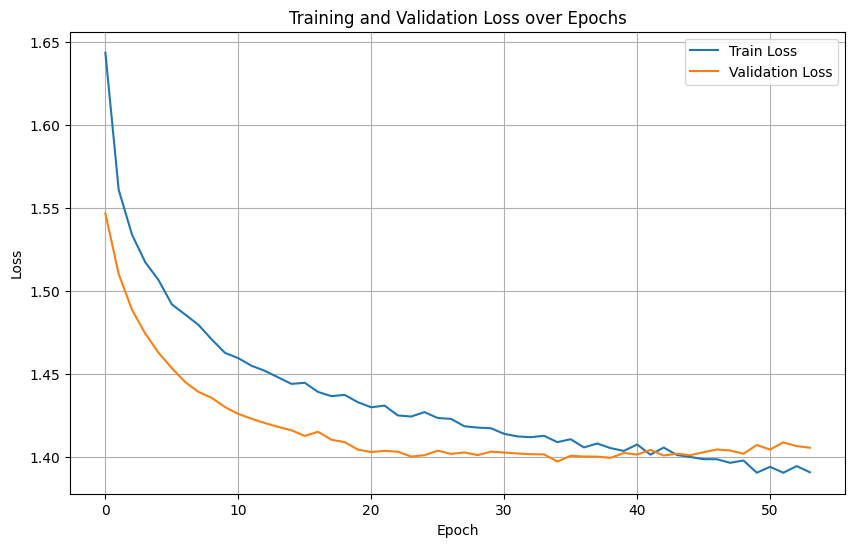

Test Accuracy: 0.4621


In [ ]:
import torch
import torch.nn as nn
import utils  

class NewDCRNNModel(nn.Module):
    def __init__(self, pretrained_encoder, rnn_units, num_new_classes, device, input_dim, encoder_input_dim):
        super(NewDCRNNModel, self).__init__()
        self.encoder = pretrained_encoder
        self.rnn_units = rnn_units
        self.device = device
        self.num_nodes = 19  # Must match the pretrained model

        # Input projection layer to adapt new input_dim to expected encoder input_dim
        self.input_projection = nn.Linear(input_dim, encoder_input_dim)

        self.fc = nn.Linear(rnn_units, num_new_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_seq, seq_lengths, supports):
        # input_seq: (batch_size, seq_len, num_nodes, input_dim)
        input_seq = input_seq.transpose(0, 1)  # => (seq_len, batch_size, num_nodes, input_dim)

        # Project input features to match encoder's expected input_dim
        seq_len, batch_size, num_nodes, input_dim = input_seq.shape
        input_seq = self.input_projection(input_seq)  # shape: (seq_len, batch_size, num_nodes, encoder_input_dim)

        init_hidden_state = self.encoder.init_hidden(batch_size).to(self.device)
        _, final_hidden = self.encoder(input_seq, init_hidden_state, supports)
        output = final_hidden.transpose(0, 1)  # => (batch_size, seq_len, rnn_units * num_nodes)

        last_out = utils.last_relevant_pytorch(output, seq_lengths, batch_first=True)
        last_out = last_out.view(batch_size, num_nodes, self.rnn_units).to(self.device)

        logits = self.fc(self.relu(self.dropout(last_out)))  # => (batch_size, num_nodes, num_classes)
        pooled_logits, _ = torch.max(logits, dim=1)

        return pooled_logits  # => (batch_size, num_classes)
    
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import utils

# ======= Setup ======= #
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from args import get_args  
import sys
sys.argv = [
    'train.py',
    '--task', 'classification',
    '--graph_type', 'combined',                    
    '--load_model_path', 'pretrained_distance_graph_12s.pth.tar'
]
args = get_args()

model_full = DCRNNModel_classification(args, num_classes=7, device=device)
checkpoint = torch.load('pretrained_distance_graph_12s.pth.tar', map_location=device)
model_full.load_state_dict(checkpoint['model_state'], strict=False)
pretrained_encoder = model_full.encoder

# ======= Final Model ======= #
pre_model = NewDCRNNModel(pretrained_encoder, rnn_units=64, num_new_classes=7, device=device, input_dim=32,
    encoder_input_dim=100).to(device)
for param in pre_model.encoder.parameters():
    param.requires_grad = True

# ======= Compute Graph Supports ======= #
def compute_graph_supports(adj_mat, filter_type='laplacian'):
    supports = []
    if filter_type == 'laplacian':
        supports.append(utils.calculate_scaled_laplacian(adj_mat, lambda_max=None))
    elif filter_type == 'dual_random_walk':
        supports.append(utils.calculate_random_walk_matrix(adj_mat).T)
        supports.append(utils.calculate_random_walk_matrix(adj_mat.T).T)
    else:
        raise ValueError('Unknown filter type')
    supports = [torch.FloatTensor(s.toarray()).to(device) for s in supports]
    return supports

# ======= Dataset ======= #
inputs = torch.FloatTensor(all_feats_z)  # (N, 12, 19, 100)
labels = torch.LongTensor(yl)
seq_lengths = torch.full((len(all_feats_z),), 1, dtype=torch.long)

full_dataset = TensorDataset(inputs, labels, seq_lengths)
train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ======= Training ======= #
optimizer = optim.Adam(pre_model.fc.parameters(), lr=1e-3)
# loss_fn = nn.CrossEntropyLoss()
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=torch.unique(labels.cpu()).numpy(),
                                     y=labels.cpu().numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
supports = compute_graph_supports(adj_mat)

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 20
patience_counter = 0

for epoch in range(200):
    pre_model.train()
    total_loss = 0
    for batch_inputs, batch_labels, batch_seq_lengths in train_loader:
        batch_inputs, batch_labels, batch_seq_lengths = batch_inputs.to(device), batch_labels.to(device), batch_seq_lengths.to(device)
        optimizer.zero_grad()
        outputs = pre_model(batch_inputs, batch_seq_lengths, supports)
        loss = loss_fn(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    pre_model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_inputs, val_labels, val_seq_lengths in val_loader:
            val_inputs, val_labels, val_seq_lengths = val_inputs.to(device), val_labels.to(device), val_seq_lengths.to(device)
            val_outputs = pre_model(val_inputs, val_seq_lengths, supports)
            val_loss += loss_fn(val_outputs, val_labels).item()

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# ======= Evaluation ======= #
pre_model.eval()
correct = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for batch_inputs, batch_labels, batch_seq_lengths in test_loader:
        batch_inputs, batch_labels, batch_seq_lengths = batch_inputs.to(device), batch_labels.to(device), batch_seq_lengths.to(device)
        outputs = pre_model(batch_inputs, batch_seq_lengths, supports)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        correct += (preds == batch_labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(batch_labels.cpu().numpy())

accuracy = correct / len(test_dataset)
print(f"Test Accuracy: {accuracy:.4f}")

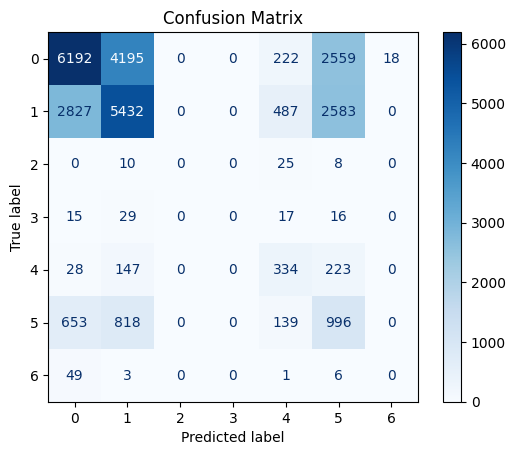

              precision    recall  f1-score   support

           0     0.6342    0.4696    0.5396     13186
           1     0.5108    0.4795    0.4947     11329
           2     0.0000    0.0000    0.0000        43
           3     0.0000    0.0000    0.0000        77
           4     0.2727    0.4563    0.3413       732
           5     0.1558    0.3822    0.2214      2606
           6     0.0000    0.0000    0.0000        59

    accuracy                         0.4621     28032
   macro avg     0.2248    0.2554    0.2281     28032
weighted avg     0.5264    0.4621    0.4832     28032



c:\Users\Atena\anaconda3\envs\htenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Atena\anaconda3\envs\htenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Atena\anaconda3\envs\htenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# After collecting all_preds and all_targets
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(all_targets, all_preds, digits=4))

In [ ]:
import torch
import numpy as np
from collections import defaultdict

def classwise_occlusion_analysis(
    model, data_loader, adj_mat, device, 
    compute_supports_func, filter_type, num_classes
):
    model.eval()
    model.to(device)

    num_nodes = adj_mat.shape[0]
    supports_orig = compute_supports_func(adj_mat, filter_type=filter_type)
    supports_orig = [s.to(device) for s in supports_orig]

    node_importance = {cls: defaultdict(float) for cls in range(num_classes)}
    edge_importance = {cls: defaultdict(float) for cls in range(num_classes)}
    class_counts = defaultdict(int)

    with torch.no_grad():
        for batch_x, batch_y, batch_seq_len in data_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_seq_len = batch_seq_len.to(device)

            outputs = model(batch_x, batch_seq_len, supports_orig)
            preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)

            for i in range(batch_x.size(0)):
                x_sample = batch_x[i:i+1]
                y_true = batch_y[i].item()
                class_counts[y_true] += 1

                sl = batch_seq_len[i:i+1]
                orig_out = model(x_sample, sl, supports_orig)
                orig_prob = torch.softmax(orig_out, dim=1)[0, y_true].item()

                # --- Node Occlusion ---
                for node in range(num_nodes):
                    x_occ = x_sample.clone()
                    x_occ[:, :, node, :] = 0
                    out_occ = model(x_occ, sl, supports_orig)
                    occ_prob = torch.softmax(out_occ, dim=1)[0, y_true].item()
                    drop = orig_prob - occ_prob
                    node_importance[y_true][node] += drop

                # --- Edge Occlusion ---
                for s_idx, s in enumerate(supports_orig):
                    for src in range(num_nodes):
                        for tgt in range(num_nodes):
                            if s[src, tgt] != 0:
                                s_occ = [s_.clone() for s_ in supports_orig]
                                s_occ[s_idx][src, tgt] = 0
                                out_occ = model(x_sample, sl, s_occ)
                                occ_prob = torch.softmax(out_occ, dim=1)[0, y_true].item()
                                drop = orig_prob - occ_prob
                                edge_importance[y_true][(src, tgt)] += drop

    # Normalize
    for cls in range(num_classes):
        if class_counts[cls] > 0:
            for node in node_importance[cls]:
                node_importance[cls][node] /= class_counts[cls]
            for edge in edge_importance[cls]:
                edge_importance[cls][edge] /= class_counts[cls]

    return node_importance, edge_importance

In [ ]:
node_imp, edge_imp = classwise_occlusion_analysis(
    model=pre_model,
    data_loader=test_loader,
    adj_mat=adj_mat,
    device=device,
    compute_supports_func=compute_graph_supports,
    filter_type='laplacian',
    num_classes=2
)

In [ ]:
import numpy as np
import os
import sys
import pickle
import networkx as nx
import collections
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import rankdata


def get_spectral_graph_positions():
    """
    # Get positions of EEG electrodes for visualizations
    """

    adj_mx_all = adjdata
    adj_mx = adj_mx_all[-1]

    node_id_dict = adj_mx_all[1]

    eeg_viz = nx.Graph()
    adj_mx = adj_mx_all[-1]
    node_id_label = collections.defaultdict()

    for i in range(adj_mx.shape[0]):
        eeg_viz.add_node(i)

    for k, v in node_id_dict.items():
        node_id_label[v] = k
    # Add edges
    for i in range(adj_mx.shape[0]):
        for j in range(
                adj_mx.shape[1]):  # do not include self-edge in visualization
            if i != j and adj_mx[i, j] > 0:
                eeg_viz.add_edge(i, j)

    pos = nx.spectral_layout(eeg_viz)
    # keep the nice shape of the electronodes on the scalp
    pos_spec = {node: (y, -x) for (node, (x, y)) in pos.items()}

    return pos_spec


def draw_graph_weighted_edge(
        adj_mx,
        node_id_dict,
        pos_spec,
        is_directed,
        title='',
        save_dir=None,
        fig_size=(
            12,
            8),
    node_color='Red',
    font_size=20,
        plot_colorbar=False):
    """
    Draw a graph with weighted edges
    Args:
        adj_mx: Adjacency matrix for the graph, shape (num_nodes, num_nodes
        node_id_dict: dict, key is node name, value is node index
        pos_spec: Graph node position specs from function get_spectral_graph_positions
        is_directed: If True, draw directed graphs
        title: str, title of the figure
        save_dir: Dir to save the plot
        fig_size: figure size

    """
    eeg_viz = nx.DiGraph() if is_directed else nx.Graph()
    node_id_label = collections.defaultdict()

    for i in range(adj_mx.shape[0]):
        eeg_viz.add_node(i)

    for k, v in node_id_dict.items():
        node_id_label[v] = k

    # Add edges
    for i in range(adj_mx.shape[0]):
        for j in range(adj_mx.shape[1]):  # since it's now directed
            if i != j and adj_mx[i, j] > 0:
                eeg_viz.add_edge(i, j, weight=adj_mx[i, j])

    edges, weights = zip(*nx.get_edge_attributes(eeg_viz, 'weight').items())

    # Change the color scales below
    k = 3
    cmap = plt.cm.Greys(np.linspace(0, 1, (k + 1) * len(weights)))
    cmap = matplotlib.colors.ListedColormap(cmap[len(weights):-1:(k - 1)])

    plt.figure(figsize=fig_size)
    nx.draw_networkx(eeg_viz, pos_spec, labels=node_id_label, with_labels=True,
                     edgelist=edges, edge_color=rankdata(weights),
                     width=fig_size[1] / 2, edge_cmap=cmap, font_weight='bold',
                     node_color=node_color,
                     node_size=250 * (fig_size[0] + fig_size[1]),
                     font_color='white',
                     font_size=font_size)
    plt.title(title, fontsize=font_size)
    plt.axis('off')
    if plot_colorbar:
        sm = plt.cm.ScalarMappable(
            cmap=cmap, norm=plt.Normalize(
                vmin=0, vmax=1))
        sm.set_array([])
        plt.colorbar(sm)
    plt.tight_layout()
    if save_dir is not None:
        plt.savefig(save_dir, dpi=300)

    plt.show()

In [ ]:
def visualize_importance_graph(adj_mx_data, node_importance, edge_importance, class_label='Class', figsize=(12, 8)):
    import matplotlib.pyplot as plt
    import networkx as nx

    # Load adj matrix
    adj_mx = adj_mx_data[2]
    node_id_dict = {k.split(' ')[-1]: v for k, v in adj_mx_data[1].items()}
    pos_spec = get_spectral_graph_positions()

    # Invert the mapping: index → label
    node_labels = {v: k for k, v in node_id_dict.items()}
    G = nx.Graph()

    for i in range(adj_mx.shape[0]):
        G.add_node(i)

    for i in range(adj_mx.shape[0]):
        for j in range(adj_mx.shape[1]):
            if i != j and adj_mx[i, j] > 0:
                G.add_edge(i, j)

    # Normalize node and edge importances
    node_colors = np.array([node_importance.get(i, 0.0) for i in range(adj_mx.shape[0])])
    edge_colors = np.array([edge_importance.get((i, j), 0.0) for i, j in G.edges()])

    # Normalize for color mapping
    node_vmin, node_vmax = node_colors.min(), node_colors.max()
    edge_vmin, edge_vmax = edge_colors.min(), edge_colors.max()

    fig, ax = plt.subplots(figsize=figsize)
    nodes = nx.draw_networkx_nodes(
        G, pos_spec, node_color=node_colors, cmap='Reds',
        node_size=1200, ax=ax, vmin=node_vmin, vmax=node_vmax
    )
    edges = nx.draw_networkx_edges(
        G, pos_spec, edge_color=edge_colors, edge_cmap=plt.cm.Blues,
        width=3, ax=ax, edge_vmin=edge_vmin, edge_vmax=edge_vmax
    )
    nx.draw_networkx_labels(G, pos_spec, labels=node_labels, font_color='black', ax=ax, font_size=12)
    ax.set_title(f"Importance Visualization - {class_label}")
    ax.axis('off')

    # Add colorbars with correct axes context
    sm_nodes = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=node_vmin, vmax=node_vmax))
    sm_nodes.set_array([])
    plt.colorbar(sm_nodes, ax=ax, orientation='vertical', label='Node Importance')

    sm_edges = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=edge_vmin, vmax=edge_vmax))
    sm_edges.set_array([])
    plt.colorbar(sm_edges, ax=ax, orientation='vertical', label='Edge Importance')

    plt.tight_layout()
    plt.show()

In [ ]:
class_id = 0
visualize_importance_graph(adjdata, node_imp[class_id], edge_imp[class_id], class_label=f"Class {class_id}")

In [ ]:
class_id = 1
visualize_importance_graph(adjdata, node_imp[class_id], edge_imp[class_id], class_label=f"Class {class_id}")